# Glioma Grading using Voting Classifier

Import libraries

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Load the dataset

In [2]:
df = pd.read_csv("datasets/TCGA_InfoWithGrade.csv")
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,51.30,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,38.72,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35.17,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,32.78,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,31.51,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,1,77.89,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
835,1,0,85.18,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
836,1,1,77.49,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
837,1,0,63.33,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Split features and class column

In [3]:
X = df.drop("Grade", axis=1)
y = pd.DataFrame(df["Grade"]).copy()

Split the train and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.2, random_state=42)

Scale the "Age_at_diagnosis" column

In [5]:
scaler = StandardScaler()
scaler.fit(X_train[["Age_at_diagnosis"]])

X_train["Age_at_diagnosis"] = scaler.transform(X_train[["Age_at_diagnosis"]])
X_test["Age_at_diagnosis"] = scaler.transform(X_test[["Age_at_diagnosis"]])

## Model Training

Train voting classifier model using 3-6 machine learning model

In [6]:
seed = 1
lr = LogisticRegression(random_state=seed)
svm = SVC(random_state=seed, probability=True)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=seed)
adaboost = AdaBoostClassifier(random_state=seed)

classifiers = [('lr', lr), ('svm', svm), ('knn', knn), ('rf', rf), ('adaboost', adaboost)]

voting_classifiers = []
for n in range(3, 6):
    for subset in combinations(classifiers, n):
        voting_classifier = VotingClassifier(estimators=list(subset), voting='soft')
        voting_classifiers.append(voting_classifier)

results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_dff = pd.DataFrame(columns=['Classifier', 'TP', 'FP', 'FN', 'TN'])

precs = []
recs = []

for vc in voting_classifiers:
    vc.fit(X_train, y_train)
    y_pred = vc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    prec, rec, _ = precision_recall_curve(y_test, y_pred)
    precs.append(prec)
    recs.append(recs)
    f1 = f1_score(y_test, y_pred)
    clf_names = [name for name, _ in vc.estimators]
    clf_names_str = ', '.join(clf_names)
    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()
    results_df = results_df.append({'Classifier': clf_names_str, 'Accuracy': accuracy,
                                    'Precision': precision, 'Recall': recall, 'F1 Score': f1},
                                   ignore_index=True)
    results_dff = results_dff.append({'Classifier': clf_names_str, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn},ignore_index=True)


## Model Evaluation

Shows the predictive performance on testing set

In [7]:
results_df.style.format(precision=3)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,"lr, svm, knn",0.869,0.820,0.924,0.869
1,"lr, svm, rf",0.875,0.830,0.924,0.874
2,"lr, svm, adaboost",0.869,0.820,0.924,0.869
3,"lr, knn, rf",0.875,0.830,0.924,0.874
4,"lr, knn, adaboost",0.875,0.822,0.937,0.876
5,"lr, rf, adaboost",0.875,0.830,0.924,0.874
6,"svm, knn, rf",0.875,0.830,0.924,0.874
7,"svm, knn, adaboost",0.869,0.820,0.924,0.869
8,"svm, rf, adaboost",0.863,0.826,0.899,0.861
9,"knn, rf, adaboost",0.869,0.828,0.911,0.867


Show the confusion matrix

In [8]:
results_dff

,Classifier,TP,FP,FN,TN
0,"lr, svm, knn",73,16,6,73
1,"lr, svm, rf",74,15,6,73
2,"lr, svm, adaboost",73,16,6,73
3,"lr, knn, rf",74,15,6,73
4,"lr, knn, adaboost",73,16,5,74
5,"lr, rf, adaboost",74,15,6,73
6,"svm, knn, rf",74,15,6,73
7,"svm, knn, adaboost",73,16,6,73
8,"svm, rf, adaboost",74,15,8,71
9,"knn, rf, adaboost",74,15,7,72


Visualize the ROC curve

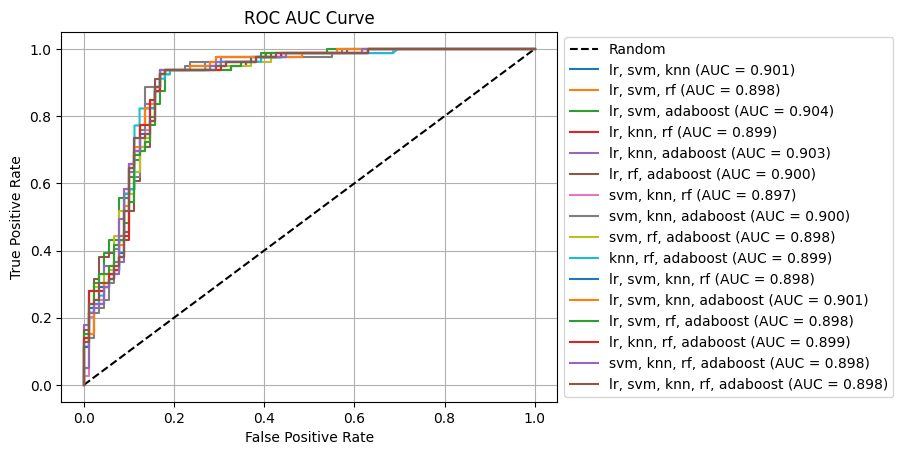

In [9]:
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for vc in voting_classifiers:
    vc.fit(X_train, y_train)
    y_pred_proba = vc.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    clf_names = [name for name, _ in vc.estimators]
    clf_names_str = ', '.join(clf_names)
    plt.plot(fpr, tpr, label=f'{clf_names_str} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

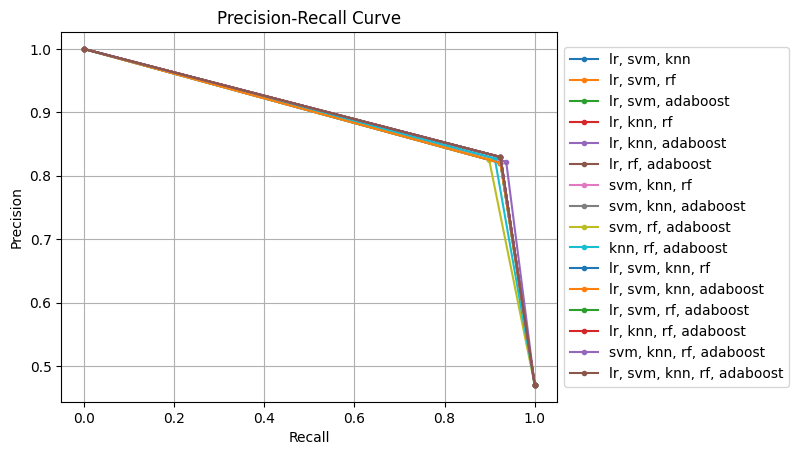

In [13]:
for vc in voting_classifiers:
    vc.fit(X_train, y_train)
    y_pred = vc.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    clf_names = [name for name, _ in vc.estimators]
    clf_names_str = ', '.join(clf_names)
    plt.plot(recall, precision, marker='.', label=clf_names_str)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()